<a href="https://colab.research.google.com/github/lanej5/mlb/blob/main/elo/elo_2022_07_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#notebook setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/My Drive/mlb/modelling/models")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load and prepare data

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

features = pd.read_parquet(
    '/content/drive/My Drive/mlb/features/features.parquet',
    columns=['game_id', 'date', 'visitor_id', 'home_id', 'season', 'W'])

In [ ]:
features.head(10)

,game_id,date,visitor_id,home_id,season,W
0,0,1990-04-09,5,2,1990,1
1,1,1990-04-09,11,0,1990,0
2,2,1990-04-09,23,3,1990,1
3,3,1990-04-09,8,10,1990,1
4,4,1990-04-09,14,13,1990,1
5,5,1990-04-09,18,6,1990,0
6,6,1990-04-09,21,20,1990,1
7,7,1990-04-09,26,24,1990,0
8,8,1990-04-09,29,28,1990,1
9,9,1990-04-10,29,28,1990,1


In [ ]:
# note that the 2020 pandemic season had a low number of games
features.groupby('season')['game_id'].count()

season
1990    2096
1991    2095
1992    2097
1993    2260
1994    1593
1995    2008
1996    2258
1997    2257
1998    2419
1999    2415
2000    2416
2001    2416
2002    2413
2003    2417
2004    2415
2005    2418
2006    2416
2007    2418
2008    2415
2009    2417
2010    2417
2011    2416
2012    2417
2013    2418
2014    2417
2015    2416
2016    2415
2017    2417
2018    2418
2019    2416
2020     894
2021    2416
Name: game_id, dtype: int64

In [ ]:
# teams are indexed 0 - 29
# (teams that changed name between seasons, e.g. MON -> WAS, are considered the same)
assert set(features['home_id'].to_list()) == {n for n in range(30)}

# model base class

In [ ]:
# model.py
"""Define Model abstract base class and Forecast module."""
from typing import List, Dict
from abc import ABC, abstractmethod
from dataclasses import dataclass
from __future__ import annotations

from utils import save_parameters


@dataclass
class Game():
  """Representation of games."""
  home: str
  visitor: str


class Model(ABC):
  """Model abstract base class.

  Represents a model that predicts win probabilities
  for individual games and has an online learning
  algorithm (implemented by step).
  """
  @classmethod
  def from_params(cls, params) -> Model:
    model = cls()
    model.params = params
    return model

  @abstractmethod
  def predict_proba(self, game: Game) -> float:
    """Predict probability that home team wins."""
    pass

  @abstractmethod
  def step(self, game: Game, result: float) -> None:
    """Perform single step parameter update."""
    pass

  def save_parameters(self, bucket_name: str, params: Dict) -> None:
    """Save model parameters."""
    save_parameters(bucket_name, params)

  def train(self, schedule: List[Game], results: List[float]) -> None:
    """Train the model with game results."""
    for game, result in zip(schedule, results):
      self.step(game, result)

# basic elo model

In [ ]:
# elo.py
"""Simple ELO model."""
import os
from typing import Dict
from dataclasses import dataclass

# from model import Model, Game
from utils import sigmoid, load_parameters


@dataclass
class ELOParams():
  """Parameters for the ELO model.
  
  a: scaling factor.
  b: y-intercept.
  ratings: regression coefficients.
  k: learning rate.
  """
  rating: List[float]
  a: float
  k: float
  b: float


class ELO(Model):
  """Simple Elo Model.

  Online logistic regression model for Bradley-Terry paired comparison of teams.
  
  Also commonly known as the Elo rating system.

  Note: the coefficient b is not learnable in this model.
  """
  def __init__(self, bucket_name: str=None):
    if bucket_name is not None:
      self.params = load_parameters(bucket_name)
    else:
      self.params = None

  def predict_proba(self, game: Game) -> float:
    """Likelihood that home team wins."""
    logit = self.params.a * (self.params.rating[game.home] - self.params.rating[game.visitor]) 
    logit += self.params.b
    return sigmoid(logit)

  def step(self, game: Game, result: float) -> None:
    """Perform a single step of SGD."""
    p = self.predict_proba(game)
    self.params.rating[game.home] += self.params.k * (result - p)
    self.params.rating[game.visitor] += self.params.k * (p - result)

  def reset_weights(self, scale):
    self.params.rating = [x * scale for x in self.params.rating]


In [ ]:
# basic test for functionality
params = ELOParams(**{
    'a': 1,
    'k': 2,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_params(params)

g = Game(**{'home': 0, 'visitor': 1})
print(elo.predict_proba(g))
elo.step(g, 1)

print(elo.params)

elo.reset_weights(.5)

print(elo.params)

0.5374298453437496
ELOParams(rating=[0.9251403093125008, -0.9251403093125008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], a=1, k=2, b=0.15)
ELOParams(rating=[0.4625701546562504, -0.4625701546562504, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], a=1, k=2, b=0.15)


# adjusted elo model

In [ ]:
# adjusted_elo.py
"""Adjusted ELO model.

TO DO: add adjustments

"""
import os
from typing import Dict
from dataclasses import dataclass

# from model import Model, Game
from utils import sigmoid, load_parameters


@dataclass
class AdjustedELOParams():
  """Parameters for the ELO model.
  
  a: scaling factor.
  b: y-intercept.
  ratings: regression coefficients.
  k: learning rate.
  """
  rating: List[float]
  a: float
  k: float
  b: float


class AdjustedELO(ELO):
  """Adjusted Elo Model.

  Same as the simple Elo model but with additional adjustments to the 
  log-likelihood coming from contextual data
  (such as starting pitcher statistics).
  """
  def predict_proba(self, game: Game) -> float:
    """Likelihood that home team wins."""
    logit = self.params.a * (self.params.rating[game.home] - self.params.rating[game.visitor]) 
    logit += self.params.b # add adjustments here
    return sigmoid(logit)


# bayesian ADF model

We follow the procedure for online bayesian logistic regression with assumed density filtering (ADF) described in Machine Learning: a probabilistic perspective, 18.5.3.2.





In [280]:
# bayes.py
"""Bayesian logistic regression model.

TO DO: finish writing step()

"""
import os
from typing import Dict
from dataclasses import dataclass
import numpy as np

# from model import Model, Game
from utils import sigmoid, load_parameters


def np_sigmoid(x):
  """Numerically stable sigmoid for numpy arrays."""
  return np.where(
    x >= 0, 
    1 / (1 + np.exp(-x)), 
    np.exp(x) / (1 + np.exp(x)))

@dataclass
class BayesParams():
  """Parameters for the Bayesian model.
  
  ratings: mean of regression coefficients.
  std: standard deviation of regression coefficients.
  a: scaling factor.
  b: y-intercept.
  k: learning rate.
  """
  rating: List[float]
  std: List[float]
  a: float
  k: float
  b: float


class Bayes(Model):
  """Simple Bayesian logisitic regression Model.

  Online Bayesian logistic regression model for Bradley-Terry paired comparison of teams.

  The posterior is computed by Monte-Carlo and then approximated by a Gaussian.
  """
  def __init__(self, bucket_name: str=None):
    if bucket_name is not None:
      self.params = load_parameters(bucket_name)
    else:
      self.params = None

  def predict_proba(self, game: Game) -> float:
    """Likelihood that home team wins."""
    logit = self.params.a * (self.params.rating[game.home] - self.params.rating[game.visitor]) 
    logit += self.params.b
    return sigmoid(logit)

  def sample_proba(self, game: Game, num_samples: int=1) -> float:
    """Sample likelihood that home team wins."""
    # home_rating = np.random.normal(
    #   self.params.rating[game.home],
    #   self.params.std[game.home],
    #   num_samples)
    # visitor_rating = np.random.normal(
    #   self.params.rating[game.visitor],
    #   self.params.std[game.visitor],
    #   num_samples)
    # logit = self.params.a * (home_rating - visitor_rating) 
    # logit += self.params.b
    # return np_sigmoid(logit)

  def step(self, game: Game, result: float) -> None:
    """Update posterior."""
    #p = self.sample_proba(game, 5_000)

    # compute posterior mean and standard deviation

    self.params.rating[game.home] =
    self.params.std[game.home] = 
    self.params.rating[game.visitor] =
    self.params.std[game.visitor] =

  def reset_weights(self, scale):
    self.params.rating = [x * scale for x in self.params.rating]
    self.params.std = 30 * [1]


SyntaxError: ignored

# glicko

# model evaluation

In [ ]:
from pandas.core.dtypes.cast import sanitize_to_nanoseconds
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('ggplot')

def train(model, features, scale_yearly=0):
    cols = features.columns.to_list() + ['p', 'home_rating', 'visitor_rating']
    df = pd.DataFrame(columns=cols)
    df[features.columns] = features
    current_season = features.loc[0, 'season']
    results = []

    for i in range(len(df)):
        if df.loc[i, 'season'] > current_season:
            model.reset_weights(scale_yearly)
            current_season = df.loc[i, 'season']

        h, v = df.loc[i, 'home_id'], df.loc[i, 'visitor_id']
        g = Game(h, v)
        p = model.predict_proba(g)
        model.step(g, df.loc[i, 'W'])

        # log values
        h_rating = model.params.rating[h]
        v_rating = model.params.rating[v]

        results.append((p, h_rating, v_rating))
    
    df[['p', 'home_rating', 'visitor_rating']] = results

    df['log_loss'] = - df['W'] * np.log(df['p']) - (1 - df['W']) * np.log(1 - df['p'])

    return df

def plot_model_performance(df):

    ll = - df.groupby('season')['log_loss'].mean()

    seasons = list(set(df['season'].to_list()))

    auc = [roc_auc_score(df.loc[df['season'] == s, 'W'], df.loc[df['season'] == s,'p']) for s in seasons]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax1 = ax.twinx()

    ax.plot(seasons, auc, 'C0-')
    ax1.plot(seasons, ll, 'C1-')

    ax.set_xlabel('season')
    ax.set_ylabel('auc', color='C0')
    ax1.set_ylabel('negative log loss', color='C1')
    ax1.grid(False)

    avg_ll = -df['log_loss'].mean()
    total_auc = roc_auc_score(df['W'], df['p'])
    ax.set_title(f'Model performance by season (avg_log_loss = {avg_ll:.2f}, roc_auc = {total_auc:.2f})')
    plt.show()
    pass

def plot_log_loss_by_week(df):
    df1 = pd.merge(
        df,
        df.groupby('season')[['date']].first().rename(columns={'date': 'season_start'}),
        how='left',
        on='season'
    )

    df1['week'] = (df1['date'] - df1['season_start']).dt.days // 7

    df1 = df1.groupby(['season', 'week'], as_index=False)[['log_loss']].mean() #.pivot(index='week', columns='season', values='log_loss').reset_index()

    fig = px.line(
        df1,
        x="week",
        y="log_loss",
        color='season',
        title='log loss by week',
        template='ggplot2')
    fig.show()

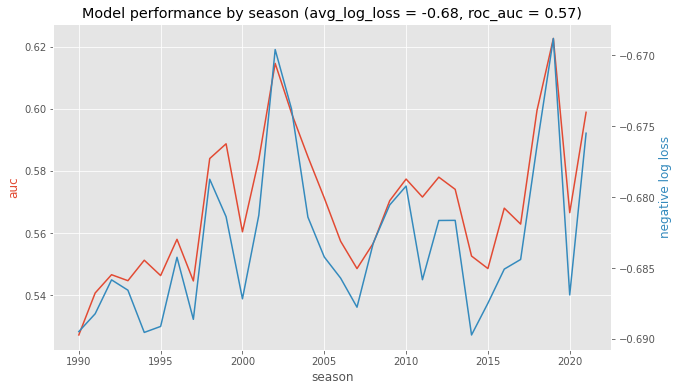

In [ ]:
from math import log

params = ELOParams(**{
    'a': log(10) / 400,
    'k': 4,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_params(params)

df = train(elo, features, 1)

plot_model_performance(df)

In [ ]:
plot_log_loss_by_week(df)

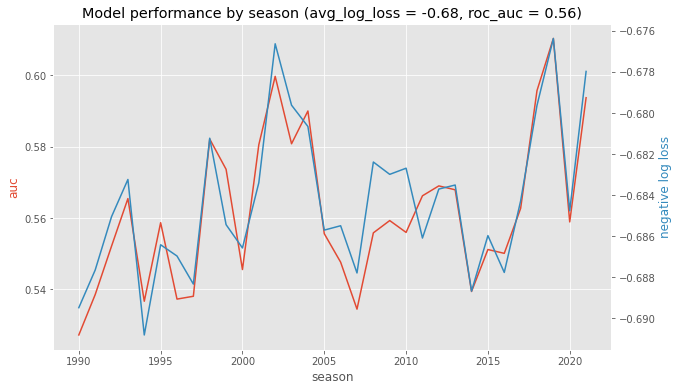

In [ ]:
params = ELOParams(**{
    'a': log(10) / 400,
    'k': 4,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_params(params)

df = train(elo, features, 0)

plot_model_performance(df)

In [ ]:
plot_log_loss_by_week(df)

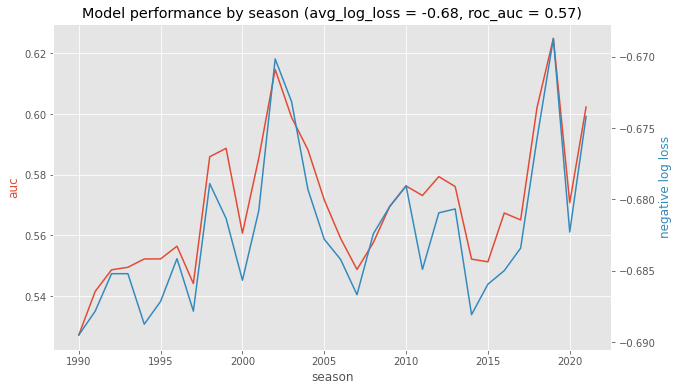

In [ ]:
params = ELOParams(**{
    'a': log(10) / 400,
    'k': 4,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_params(params)

df = train(elo, features, 0.8)

plot_model_performance(df)

In [ ]:
plot_log_loss_by_week(df)

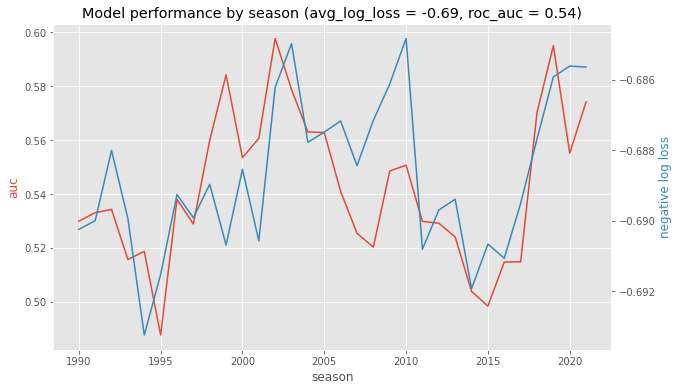

In [ ]:
params = ELOParams(**{
    'a': log(10) / 400,
    'k': .1,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_params(params)

df = train(elo, features, 1)

plot_model_performance(df)

In [ ]:
plot_log_loss_by_week(df)